In [1]:
import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding
import pandas as pd
from scipy.spatial.distance import euclidean, hamming
from ensemble_machine.model import EnsembleMachine
from lasagne import updates
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import theano

from ensemble_machine.model import model_representation_by_increasing_mean

ramp = 4

In [2]:
obj = pickle.load(open("result_ramp%d.dat" % (ramp,)))

In [3]:
obj.keys()

['pred',
 'num_prediction',
 'y_dim',
 'fold_filename_list',
 'names',
 'mds',
 'pca']

In [3]:
num_folds = obj["pred"].shape[1]
num_prediction = obj["num_prediction"]
y_dim = obj["y_dim"]
o = obj["pred"]
o = o.reshape( (o.shape[0], o.shape[1], o.shape[2]/y_dim, y_dim) )
o = o[:, :, 0:num_prediction, :]
o = o.reshape( (o.shape[0], o.shape[1], o.shape[2] * o.shape[3]) )
o = o[:, 0:num_folds, :]
o = o.reshape( (o.shape[0], o.shape[1]*o.shape[2]) )
o = o.astype(theano.config.floatX)
es = EnsembleMachine(n_components=2)
es.fit_with_mds(o, n_components=o.shape[1])
print(es.stress_)
Z = es.Z.get_value()
Y = es.Y.get_value()

breaking at iteration 2 with stress 5.04870979341e-29
breaking at iteration 2 with stress 5.04870979341e-29
breaking at iteration 2 with stress 0.0
breaking at iteration 2 with stress 0.0
breaking at iteration 2 with stress 0.0
breaking at iteration 2 with stress 5.04870979341e-29
breaking at iteration 2 with stress 0.0
breaking at iteration 2 with stress 0.0
breaking at iteration 2 with stress 0.0
breaking at iteration 2 with stress 0.0
0.0


(800, 0.0)
(700, 0.0)
(500, 0.0)
(300, 0.0)
(100, 0.0)
(50, 0.0)
(30, 0.0)
(20, 0.0)
(10, 0.0)
(2, 0.0)


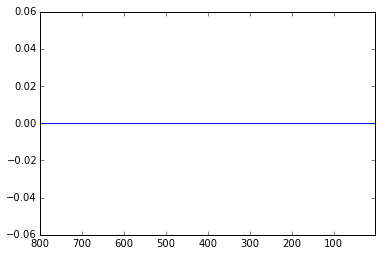

In [5]:
d=[]
dim = (800, 700, 500, 300, 100, 50, 30, 20 ,10, 2)
plt.xlim((dim[0], dim[-1]))
for i in dim:
    m = MDS(n_components=i)
    m.fit(o)
    d.append(m.stress_)
    print(i, m.stress_)
plt.plot(dim, d)

In [4]:
scores_csv = pd.read_csv("scores_ramp%d.csv" % (ramp,))
filter_names = np.array([False] * len(scores_csv))
for name in obj["names"]:
    filter_names |= (scores_csv["model"]==name.split("#")[1])

scores_csv = scores_csv[filter_names]
scores = [0] * len(obj["names"])
contrib = [0] * len(obj["names"])
only_model_names = [""] * len(obj["names"])
ind = {}
for i, name in enumerate(obj["names"]):
    ind[name] = i
for i, (model_name, s, c) in enumerate(zip(scores_csv["team"]+"#"+scores_csv["model"], 
                            scores_csv["score"],
                            scores_csv["contributivity"])):
    if model_name in ind:
        scores[ind[model_name]] = s
        contrib[ind[model_name]] = c
        only_model_names[ind[model_name]] = scores_csv["model"][ind]
scores = np.array(scores)
contrib = np.array(contrib)

In [5]:
columns = ["x", "y", "score", "contrib", "name", "team", "tag", "team_id"]

data = pd.DataFrame(columns=columns)

data["x"] = Z[:, 0]
data["y"] = Z[:, 1]
data["score"] = scores
data["contrib"] = contrib
data["name"] = obj["names"]
data["team"] = [name.split("#")[0] for name in obj["names"]]
data["tag"] = [name.split("#")[1] for name in obj["names"]]

t = list(set(data["team"].tolist()))
ind = {a:i for i, a in enumerate(t)}
data["team_id"] = [ind[tname] + 1 for tname in data["team"]]
print(data)

          x         y   score  contrib                name  team  \
0  0.014237  0.002401  0.4509       81   Delf#feature_drop  Delf   
1 -0.014237 -0.002401  0.4485      170  Delf#very_slow_xgb  Delf   

             tag  team_id  
0   feature_drop        1  
1  very_slow_xgb        1  


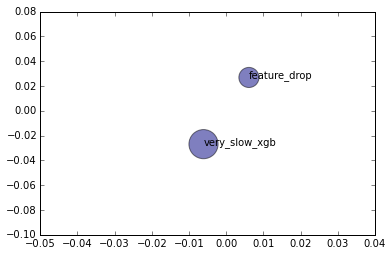

In [8]:
D = data[data["contrib"] > 2]
#D = data[data["team"].str.contains("NeuralTheano")]
#D = data
plt.scatter(D["x"], D["y"], s=D["contrib"]*5, c=D["team_id"], alpha=0.5)
for name, x, y in zip(D["tag"], D["x"], D["y"]):
    plt.annotate(name, xy=(x,y))
plt.show()

In [6]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import hashlib
target_column_name = 'target'
train_filename = "train.csv"
test_filename = "test.csv"
skf_test_size = 0.5
random_state = 57
n_CV = 27 * 3
def get_hash_string_from_indices(index_list):
    """We identify files output on cross validation (models, predictions)
    by hashing the point indices coming from an skf object.

    Parameters
    ----------
    test_is : np.array, shape (size_of_set,)

    Returns
    -------
    hash_string
    """
    hasher = hashlib.md5()
    hasher.update(index_list)
    return hasher.hexdigest()

def get_hashes(skf):
    h = []
    for train_is, test_is in skf:
        print(type(train_is)) 
        hash_string = get_hash_string_from_indices(train_is)
        h.append(hash_string)
    return h
# X is a list of dicts, each dict is indexed by column
def read_data(df_filename):
    df = pd.read_csv(df_filename, index_col=0) # this drops the id actually
    y_array = df[target_column_name].values
    X_dict = df.drop(target_column_name, axis=1).to_dict(orient='records')
    return X_dict, y_array

def prepare_data():
    pass
    # train and tes splits are given
    
def split_data(num_folds=n_CV):
    X_train_dict, y_train_array = read_data(train_filename)
    #X_test_dict, y_test_array = read_data(test_filename)
    skf = StratifiedShuffleSplit(y_train_array, n_iter=num_folds,
        test_size=skf_test_size, random_state=random_state)
    return X_train_dict, y_train_array, skf

class FeatureExtractor(object):
 
    def __init__(self):
        pass
 
    def fit(self, X_dict, y):
        pass
 
    def transform(self, X_dict):
        cols = X_dict[0].keys()
        return np.array([[instance[col] for col in cols] for instance in X_dict])
    
X_all, y_all, skf = split_data(num_folds)
skf = list(skf)
skf = skf[0:num_folds]
X_all = FeatureExtractor().transform(X_all).astype(theano.config.floatX)
s = StandardScaler()
X_all = s.fit_transform(X_all)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(y_all)
print(label_encoder.classes_)

['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']


In [7]:
X = np.zeros( (  num_prediction, X_all.shape[1], num_folds) )
y = np.empty((X.shape[0], num_folds), dtype=object)
fold = 0

idx_rest = np.ones((X_all.shape[0],))

for train, test in skf:
    print(test)
    X[:, :, fold] = X_all[test][0:num_prediction]
    y[:, fold] = y_all[test][0:num_prediction]
    fold += 1
    idx_rest[test] = False

idx_rest = idx_rest.astype(np.bool)
X = X.transpose((0, 2, 1))
X = X.reshape( (X.shape[0]*X.shape[1], X.shape[2]) )    
y = y.flatten()
print(X.shape)
print(y.shape)

print(o.shape)

[56303 14095 30894 ..., 44087 55969  4965]
(30937, 93)
(30937,)
(2, 278433)


In [8]:
from sklearn.cross_validation import StratifiedShuffleSplit

X = X.astype(theano.config.floatX)
y = y.astype(np.int32)

test_size = 0.25
to = int(X.shape[0]*(1-test_size))
X_train, y_train = X[0:to], y[0:to]
X_test, y_test = X[to:], y[to:]

In [9]:
import matplotlib.pyplot as plt
def st(stats, name):
    return [a[name] for a in stats]

#plt.plot(st(batch_optimizer.stats, "loss"), label="loss")
#plt.plot(st(batch_optimizer.stats, "loss_accuracy"), label="loss_accuracy")
#plt.plot(st(batch_optimizer.stats, "loss_ensemble_machine"), label="loss_ensemble_machine")
plt.plot(st(batch_optimizer.stats, "accuracy"), label="accuracy")

plt.legend()
plt.show()

NameError: name 'batch_optimizer' is not defined

In [10]:
new_models_predictions = [
    (es.predict_proba(X)).flatten()[np.newaxis, :]
    for model in models_new]
a=np.concatenate( [Y] + new_models_predictions, axis=0)
es_2 = EnsembleMachine(n_components=2)
es_2.fit_with_pca(a)
Z_ = es_2.Z.get_value()

NameError: name 'models_new' is not defined

In [13]:
data = pd.DataFrame(columns=columns)
scores_new = np.array(scores.tolist() + [0] * len(models_new))
contrib_new = np.array(contrib.tolist() + [10] * len(models_new))
names_new = obj["names"] + ["new_team#new"] * len(models_new)
data["x"] = Z_[:, 0]
data["y"] = Z_[:, 1]
data["score"] = scores_new
data["contrib"] = contrib_new
data["name"] = names_new
data["team"] = [name.split("#")[0] for name in names_new]
data["tag"] = [name.split("#")[1] for name in names_new]
t = list(set(data["team"].tolist()))
ind = {a:i for i, a in enumerate(t)}
data["team_id"] = [ind[tname] + 1 for tname in data["team"]]

NameError: name 'models_new' is not defined

ValueError: First argument must be a sequence

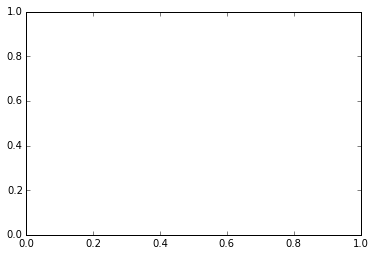

In [14]:
D = data[data["contrib"] > 2]
#D = data[data["team"].str.contains("NeuralTheano")]
plt.scatter(D["x"], D["y"], s=D["contrib"]*10, c=D["team_id"], alpha=0.5)
for name, x_, y_ in zip(D["tag"], D["x"], D["y"]):
    plt.annotate(name, xy=(x_,y_))

plt.show()

In [11]:
def log_multiclass(pred, y):
    probs = pred[np.arange(pred.shape[0]), y]
    probs = np.maximum(np.minimum(probs, 1 - 1e-15), 1e-15)
    return -np.mean(np.log(probs))

for i in range(len(models_new)):
    pred = getattr(es, "predict_%d" % (i,))
    pred_proba = getattr(es, "predict_proba_%d" % (i,))
    print( log_multiclass(pred_proba(X), y) )
    print( data["score"][teacher_id] )
    #(pred(X_all[idx_rest])==y[idx_rest]).mean()

NameError: name 'models_new' is not defined

In [16]:
plt.hist(teacher_pred, normed=True, label='teacher', alpha=0.5)
plt.hist(model_pred, normed=True, label='student', alpha=0.5)
plt.legend()

NameError: name 'teacher_pred' is not defined

In [26]:
#models = np.concatenate((o[2), axis=0)
models = o
models = models.astype(theano.config.floatX)
models = models.reshape((models.shape[0], models.shape[1] / y_dim, y_dim))
models = models.transpose((1, 0, 2))
models_train, models_test = models[0:to], models[to:]
print(models_train.shape)

(23202, 2, 9)


In [ ]:
from lasagne import init, nonlinearities, layers
from lasagne.generative.neural_net import NeuralNet
from lasagne.easy import BatchOptimizer, LightweightModel

import theano.tensor as T
from collections import OrderedDict
def logloss(pred, y): 
    probs = pred[np.arange(pred.shape[0]), y]
    probs = np.maximum(np.minimum(probs, 1 - 1e-15), 1e-15)
    return -np.mean(np.log(probs))

         
x_in = layers.InputLayer(shape=(None, X.shape[1]))
h = layers.DenseLayer(x_in, num_units=100,
                      W=init.GlorotUniform(),
                      nonlinearity=nonlinearities.rectify)
y_out = layers.DenseLayer(h, num_units=9,
                          W=init.GlorotUniform(),
                          nonlinearity=nonlinearities.softmax)
nnet_x_to_y = LightweightModel([x_in],
                               [y_out])

class MyBatchOptimizer(BatchOptimizer):

    def iter_update(self, epoch, nb_batches, iter_update_batch):
        res = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        res.update(OrderedDict({
                "accuracy": (self.model.predict(X_train)==y_train).mean(),
                "accuracy_test": (self.model.predict(X_test)==y_test).mean(),
                "logloss_test": (logloss(self.model.predict_proba(X_test), y_test))
        }))
        return res

batch_optimizer = MyBatchOptimizer(max_nb_epochs=30,
                                   optimization_procedure=(updates.adadelta, {"learning_rate" : 1}),
                                   batch_size=100,
                                   patience_nb_epochs=20,
                                   patience_progression_rate_threshold=0.0001,
                                   report_each=1,
                                   verbose=1)

def loss(pred, real, models):
    lambda_ = 1. # how much give importance to logloss compared to kl
    loss_kl = -(models * T.log(pred.dimshuffle(0, 'x', 1))).mean(axis=(1, 2))
    loss =  lambda_ * T.nnet.categorical_crossentropy(pred, real) + (1 - lambda_) * loss_kl
    return loss

model = NeuralNet(nnet_x_to_y, batch_optimizer=batch_optimizer, loss_function=loss)
print(models_train.shape)
model.fit(X_train, y_train, optional={"models":(models_train)})